In [2]:
import sys
import os
import time
import pandas as pd
import numpy as np
import collections
import re
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

In [20]:
def removeChars(text):
    return re.sub("[!#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~']", '', text)

def getData():
    comments = pd.read_csv('mediaKrytyk-comments-analysis-dictParser-emotionsList.csv')
    comments.loc[comments.emotion == 'neutral', 'emotion'] = "negative"
    comments['text'] = map(removeChars, comments['text'])
    comments['lemmatisation'] = map(removeChars, comments['lemmatisation'])
    comments = comments.reset_index()   
    return comments

In [4]:
#split (0.8 train_data 0.2 test_data)
def split_prepereData(split, comments):
    data = np.empty((0))
    data_labels = np.empty((0))

    train_data = pd.DataFrame()
    test_data = pd.DataFrame()

    length_train_data = int(split * len(comments))
    train_data = comments[:length_train_data]
    test_data = comments[length_train_data:]
  
    for index, train_data in train_data.iterrows():
        data = np.append(data, train_data['text'])
        data_labels = np.append(data_labels, train_data['emotion'])
    return [data, data_labels, test_data]

In [5]:
def prepereData(comments):  
    data = np.empty((0))
    data_labels = np.empty((0))
  
    for index, train_data in comments.iterrows():
        data = np.append(data, train_data['text'])
        data_labels = np.append(data_labels, train_data['emotion'])
    return [data, data_labels]

In [6]:
def prepereData_lemmatisation(comments):  
    data = np.empty((0))
    data_labels = np.empty((0))
  
    for index, train_data in comments.iterrows():
        data = np.append(data, train_data['lemmatisation'])
        data_labels = np.append(data_labels, train_data['emotion'])
    return [data, data_labels]

In [7]:
def SVM_liblinear(iterations, dataset, is_shuffle):
    data = dataset[0]
    data_labels = dataset[1]
    
    sss = StratifiedKFold(n_splits=iterations, shuffle=is_shuffle)

    for train_index, test_index in sss.split(data, data_labels):
        train_data = data[train_index]
        train_labels = data_labels[train_index]
        
        vectorizer = TfidfVectorizer(min_df=5,max_df = 0.8,sublinear_tf=True,use_idf=True)
        train_vectors = vectorizer.fit_transform(train_data)
    
        classifier_liblinear = svm.LinearSVC()
        classifier_liblinear.fit(train_vectors, train_labels)
        
    return [classifier_liblinear,vectorizer]

In [8]:
def SCV_detectingEmotions(classifier, vectorizer, test_data):
    test_vectors = vectorizer.transform(test_data)
    prediction_liblinear = classifier.predict(test_vectors)
    return prediction_liblinear

In [9]:
def createDataAfterClassifier(data, detectedEmotion):
    result_df = pd.DataFrame({"text": data['text'], "detectedEmotion": detectedEmotion, 'emotion': data['emotion']})
    return result_df

In [10]:
def get_length(text):
    return len(text.split())

def get_length_bin(length):
    return length / 10

def get_score(result):
    return 1 if result else 0

def prepereDataForPlot(result_df):
    result_df['correct_guess'] = result_df['detectedEmotion'] == result_df['emotion']
    result_df['score'] = map(get_score, result_df['correct_guess'])
    result_df['words'] = map(get_length, result_df['text'])
    #create group with 10 elements
    result_df['text_length_bin'] = map(get_length_bin, result_df['words'])    
    return result_df

In [11]:
def createPlotByScore(data):
    grouped = data.groupby('words', as_index=False)['score'].mean()
    fig, ax = plt.subplots()
    x = grouped.words
    y = grouped.score
    fit = np.polyfit(x, y, deg=1)
    ax.plot(x, fit[0] * x + fit[1], color='red')
    ax.scatter(x, y)
    
    plt.xlabel('Lenght of text')
    plt.ylabel('Efficacy')
    
    fig.show()

In [12]:
#zaleznosc oceny od wykrytej emocji
def createPlotByRate(data):
    data = data.round({'rate': 0})   
    grouped = data.groupby('rate', as_index=False)['score'].mean()
    fig, ax = plt.subplots()
    x = grouped.rate
    y = grouped.score
    fit = np.polyfit(x, y, deg=1)
    ax.plot(x, fit[0] * x + fit[1], color='red')
    ax.scatter(x, y)
    
    plt.xlabel('Rate')
    plt.ylabel('Efficacy')

    fig.show()

In [13]:
def splitData(data, split):  
    train_data = pd.DataFrame()
    test_data = pd.DataFrame()

    length_train_data = int(split * len(data))
    train_data = data[:length_train_data]
    test_data = data[length_train_data:]
    
    return [train_data, test_data]

In [185]:
#create model
data = getData()
preparedData = prepereData_lemmatisation(data)
[data, data_labels, test_data] = split_prepereData(0.8,preparedData)
dataset = [data, data_labels]
[classifier, vectorizer] = SVM_liblinear(10, dataset, True)

#testing dataset
#testData = pd.read_csv('FilmWeb-movies_reviews-analysis-dictParser.csv')
#testData['comment'] = map(removeChars, testData['lemmatisation'])

#testData['lemmatisation']
detectedEmotion = SCV_detectingEmotions(classifier,vectorizer,testData['lemmatisation'])

result_df = pd.DataFrame({"text": testData['comment'], "detectedEmotion": detectedEmotion, 'emotion': testData['emotion'], 'rate': testData['rate']})

AttributeError: 'list' object has no attribute 'iterrows'

In [171]:
result_df = prepereDataForPlot(result_df)

/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


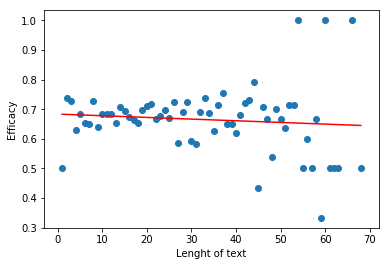

In [31]:
createPlotByScore(result_df)

In [172]:
#bez lematyzacji
result_df['correct_guess'] = result_df['detectedEmotion'] == result_df['emotion']
result_df.groupby('correct_guess').size()

correct_guess
False     94
True     225
dtype: int64

In [169]:
getEfficacy(result_df)

75

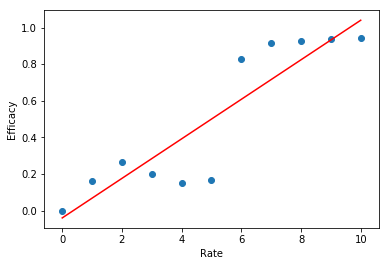

In [32]:
createPlotByRate(result_df)

In [177]:
import scipy.stats as stats

stats.spearmanr(result_df['rate'], result_df['score'])   0.4456226408609416

SpearmanrResult(correlation=0.4456226408609416, pvalue=5.736495108061057e-17)

In [174]:
stats.kendalltau(result_df['rate'], result_df['score'])

KendalltauResult(correlation=0.39247611399310106, pvalue=1.917155637739891e-15)

Text(0,0.5,u'Efficacy')

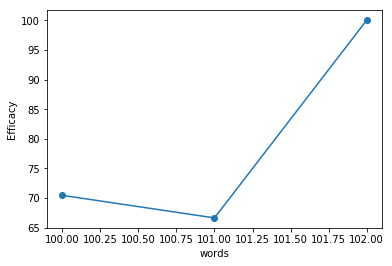

In [175]:
grouped = result_df.groupby('words', as_index=False)['score'].mean()
fig, ax = plt.subplots()
x = grouped.words
y = grouped.score*100
plt.plot(x,y,marker='o')
plt.xlabel('words')
plt.ylabel('Efficacy')

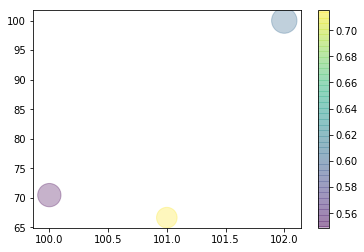

In [176]:
N = len(grouped)
rng = np.random.RandomState(0)
colors = rng.rand(N)
sizes = 1000 * rng.rand(N)

plt.scatter(x, y, c=colors, s=sizes, alpha=0.3,
            cmap='viridis')
plt.colorbar();  # show color scale

In [89]:
def getResults(result_df):
    return result_df.groupby('correct_guess').size()

In [90]:
def getEfficacy(result_df):
    [false, true] = result_df.groupby('correct_guess').size()
    return (true*100)/(false+true)

In [178]:
positives = result_df.loc[result_df['emotion'] == 'positive']

In [179]:
getResults(positives)

correct_guess
False     42
True     207
dtype: int64

In [180]:
getEfficacy(positives)

83

In [181]:
negatives = result_df.loc[result_df['emotion'] == 'negative']

In [182]:
getResults(negatives)

correct_guess
False    52
True     18
dtype: int64

In [183]:
getEfficacy(negatives)

25